In [1]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt 
from glob import glob
from tqdm import tqdm, trange

In [35]:
images = [cv2.imread(file,0) for file in sorted(glob('output/simulated2/*'))]
# size = images[0].shape
# images = [image[:size[0]//2,:size[1]//2] for image in images]

In [36]:
def sift_matching_with_homography(img1, img2):
    gray1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
    sift = cv2.SIFT_create()
    keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)
    good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]

    if len(good_matches) > 10:
        src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 2)
        dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 2)
        H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        return H
    else:
        return None

In [37]:
sift = cv2.SIFT_create(nfeatures=1000)
def get_sift_features(image):
    return sift.detectAndCompute(image, None)

def match_sift_features(feat1, feat2, use_knn=False):
    keypoints1, descriptors1 = feat1
    keypoints2, descriptors2 = feat2
    if use_knn:
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        flann = cv2.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(descriptors1, descriptors2, k=2)
        good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]
    else:
        bf = cv2.BFMatcher()
        matches1 = bf.knnMatch(descriptors1, descriptors2, 2)
        matches2 = bf.knnMatch(descriptors2, descriptors1, 2)

        # Apply ratio test and cross-checking
        good_matches = []
        for m, n in matches1:
            if m.distance < 0.75 * n.distance:
                for n_match in matches2[m.trainIdx]:
                    if n_match.trainIdx == m.queryIdx:
                        good_matches.append(m)

    if len(good_matches) > 10:
        src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 2)
        dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 2)
        H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        return H, np.mean(mask), np.sum(mask)
    else:
        return np.eye(3), 0, 0

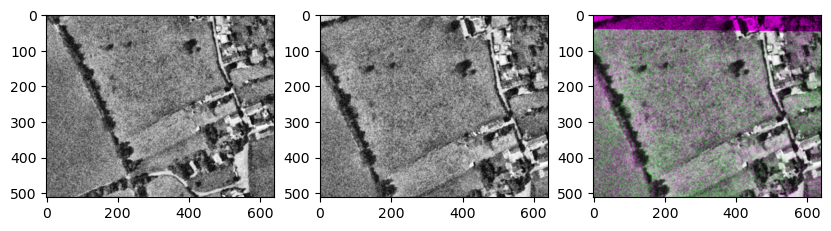

In [38]:
im0 = images[8]
im1 = images[9]
feat1 = get_sift_features(im0)
feat2 = get_sift_features(im1)
H, score, _ = match_sift_features(feat1, feat2)
im2 = cv2.warpPerspective(im0,H,(im1.shape[1],im1.shape[0]))
im3 = np.stack([im1,im2,im1],axis=-1)

fig, ax = plt.subplots(1,3,figsize=(10,10))
ax[0].imshow(im0,cmap='gray')
ax[1].imshow(im1,cmap='gray')
ax[2].imshow(im3)


In [39]:
features = []

for image in tqdm(images):
    features.append(get_sift_features(image))

N = 30

inliers = np.zeros([N,N])
ratios = np.zeros([N,N])
Hs = []

for i in trange(N):
    for j in range(i):
        H, score, inlier = match_sift_features(features[i], features[j])
        ratios[i,j] = score
        inliers[i,j] = inlier


100%|██████████| 30/30 [00:02<00:00, 11.43it/s]


In [40]:
temp = np.minimum(ratios,inliers/100)
scores = -np.log(temp + temp.T)
# scores = -np.log(ratios + ratios.T)
# scores = -np.log(inliers + inliers.T)

C:\Users\maxima\AppData\Local\Temp\ipykernel_12076\373129790.py:2: RuntimeWarning: divide by zero encountered in log
  scores = -np.log(temp + temp.T)


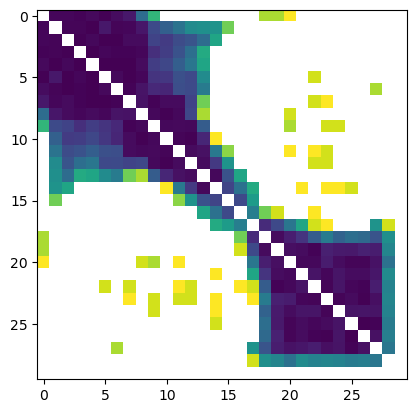

In [41]:
plt.imshow(scores)

In [42]:
import numpy as np
import networkx as nx

def lightest_path(adj_matrix, source, target):
    # Create a graph from the adjacency matrix
    G = nx.Graph()
    num_nodes = len(adj_matrix)
    
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if adj_matrix[i][j] != 0:
                G.add_edge(i, j, weight=adj_matrix[i][j])
    
    # Find the lightest path
    lightest_path = nx.shortest_path(G, source=source, target=target, weight='weight')
    
    # Calculate the total weight of the lightest path
    total_weight = nx.shortest_path_length(G, source=source, target=target, weight='weight')
    
    return lightest_path, total_weight

0 2.945820992380006 [17, 14, 13, 11, 7, 5, 0]
1 2.8691813508190482 [17, 14, 13, 11, 7, 1]
2 2.8828883592255985 [17, 14, 13, 11, 8, 2]
3 2.8394032472858597 [17, 14, 13, 11, 8, 3]
4 2.81729939204277 [17, 14, 13, 11, 7, 4]
5 2.8176501154133096 [17, 14, 13, 11, 7, 5]
6 2.8495860385547482 [17, 14, 13, 11, 7, 6]
7 2.706660993837714 [17, 14, 13, 11, 7]
8 2.677527843567772 [17, 14, 13, 11, 8]
9 2.6362427942364937 [17, 14, 13, 12, 9]
10 2.5765314047949617 [17, 14, 13, 12, 10]
11 2.5013004781798878 [17, 14, 13, 11]
12 2.451685406208431 [17, 14, 13, 12]
13 2.2494944653118836 [17, 14, 13]
14 2.0661128563728326 [17, 14]
15 1.8719568419318753 [17, 15]
16 1.4862943611198907 [17, 16]
18 0.5004775665971253 [17, 18]
19 0.7022602609070676 [17, 18, 19]
20 0.8749144122988856 [17, 18, 20]
21 0.9145275627781488 [17, 18, 19, 21]
22 0.8430822554273227 [17, 18, 19, 22]
23 0.996106723735543 [17, 18, 19, 22, 23]
24 1.0507216202055671 [17, 18, 19, 24]
25 1.0141180285440745 [17, 18, 19, 22, 25]
26 0.988544629504080

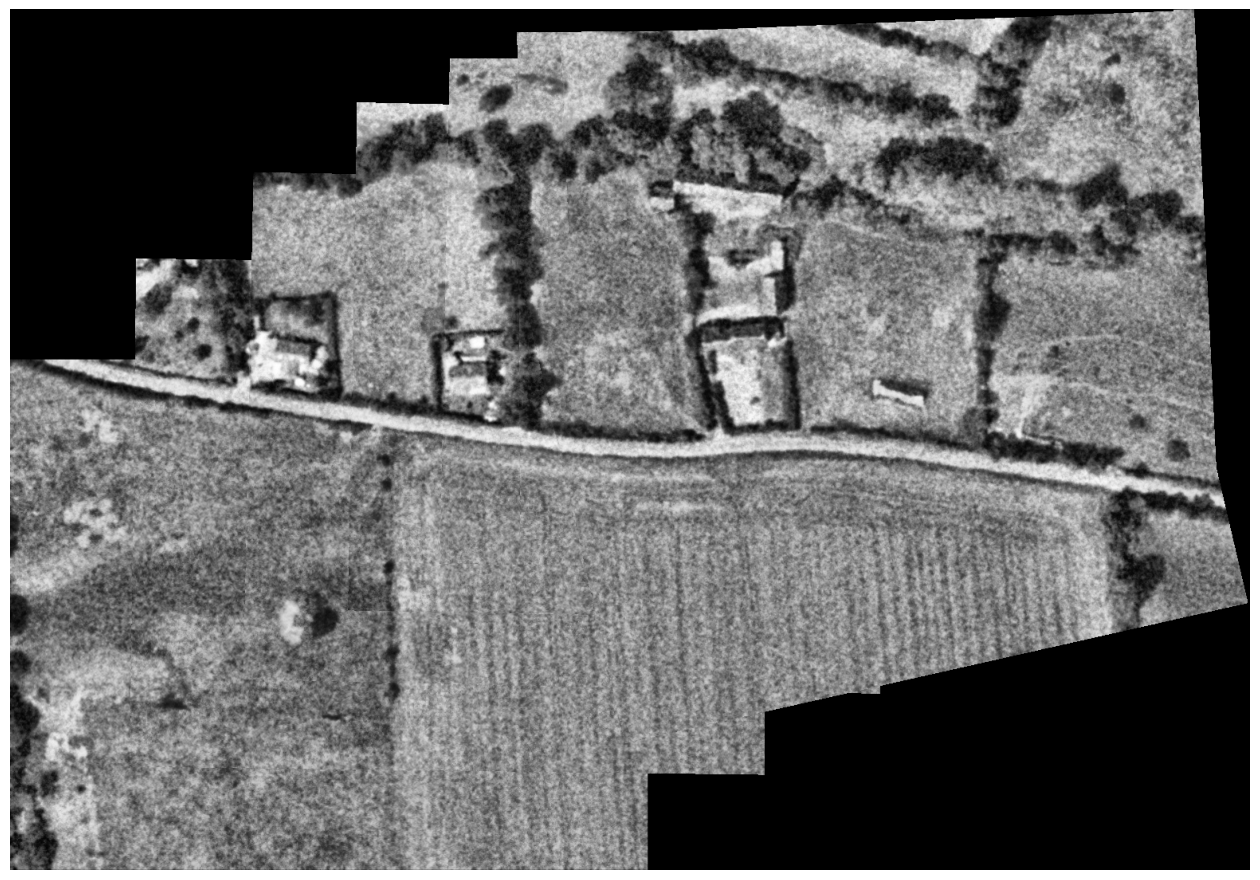

In [48]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# N = 10

# Function to find the corners of an image
def get_image_corners(image):
    h, w = image.shape[:2]
    return np.array([
        [0, 0, 1],
        [w, 0, 1],
        [w, h, 1],
        [0, h, 1]
    ]).T

# Function to transform the corners with a given homography
def transform_corners(corners, H):
    transformed_corners = H @ corners
    transformed_corners /= transformed_corners[2]  # Normalize by the last row
    return transformed_corners[:2]

# Precompute homographies and transformed corners
homographies = []
transformed_corners_list = []

dst = 17

for i in range(0, N):
    src = i
    H = np.eye(3)
    if src != dst:
        path, weight = lightest_path(scores + 0.1, dst, src)
        print(src, weight, path)
        if weight > 1.0:
            H = None
        else:    
            for j in range(1, len(path)):
                H_rel, _, _ = match_sift_features(features[path[j]], features[path[j-1]])
                H = H @ H_rel
            
    homographies.append(H)
    
    if H is None:
        continue
    
    corners = get_image_corners(images[i])
    transformed_corners = transform_corners(corners, H)
    transformed_corners_list.append(transformed_corners)

# Determine the bounds of the panorama
min_x, min_y = float('inf'), float('inf')
max_x, max_y = float('-inf'), float('-inf')

for transformed_corners in transformed_corners_list:
    min_x = min(min_x, np.min(transformed_corners[0]))
    max_x = max(max_x, np.max(transformed_corners[0]))
    min_y = min(min_y, np.min(transformed_corners[1]))
    max_y = max(max_y, np.max(transformed_corners[1]))

# Calculate the size of the final panorama
offset_x = -min_x
offset_y = -min_y
H_translation = np.array([
    [1, 0, offset_x],
    [0, 1, offset_y],
    [0, 0, 1]
])
scale_x = 1920/(max_x - min_x)
scale_y = 1080/(max_y - min_y)
scale = min(scale_x, scale_y)
H_scale = np.array([
    [scale, 0, 0],
    [0, scale, 0],
    [0, 0, 1]
])


panorama_width = int(np.ceil(max_x - min_x)*scale)
panorama_height = int(np.ceil(max_y - min_y)*scale)

# Stitch the images into the final panorama
aligned_images = []
for i in range(0, N):
    if homographies[i] is None:
        continue
    H_final = H_scale @ H_translation @ homographies[i]
    im = cv2.warpPerspective(images[i], H_final, (panorama_width, panorama_height))
    im = cv2.cvtColor(im, cv2.COLOR_GRAY2RGB)
    aligned_images.append(im)

sum_image = aligned_images[0].copy()
for image in aligned_images:
    mask = ((image > 0) * 255).astype(np.uint8)
    mask = cv2.erode(mask.astype(np.uint8), np.ones((5, 5), np.uint8))[:, :, 0]
    sum_image[mask > 0] = image[mask > 0]

plt.figure(figsize=(16, 16))
plt.imshow(sum_image, cmap='gray')
plt.axis('off')  # Hide axis
plt.show()


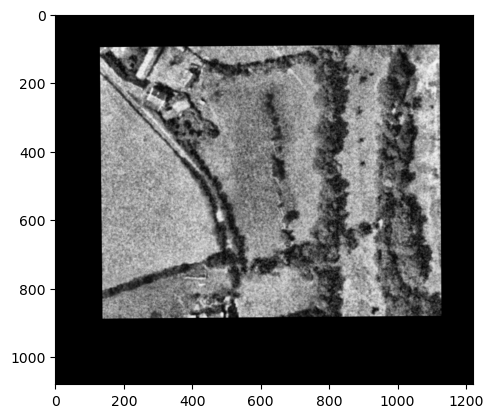

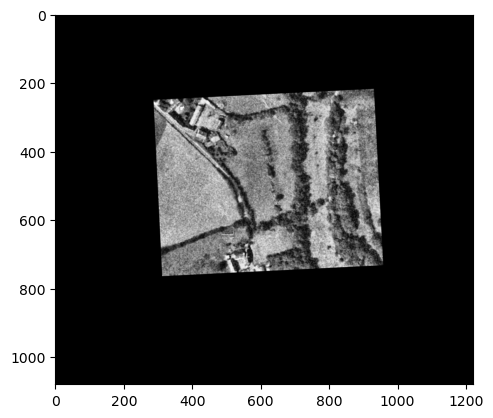

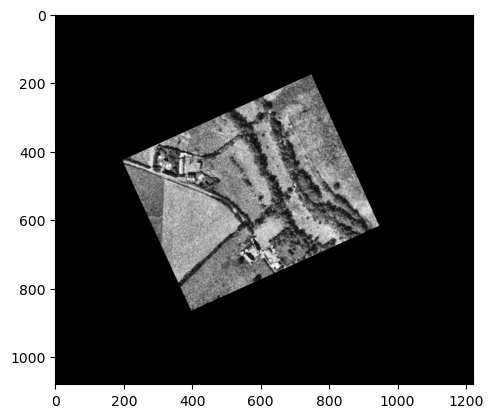

In [30]:
plt.figure()
plt.imshow(aligned_images[-1])
plt.figure()
plt.imshow(aligned_images[-2])
plt.figure()
plt.imshow(aligned_images[-3])

In [242]:
np.sqrt(np.linalg.det(H[:2,:2]))

0.2997076412764104

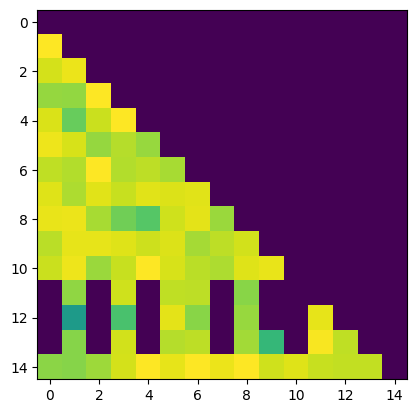

In [42]:
# plot the scores
plt.imshow(ratios)


In [ ]:
# dynamic algorithm, score[i,j] = max()

In [21]:
import numpy as np

def maximize_score(adj_matrix, start, end):
    num_nodes = len(adj_matrix)
    
    # Initialize scores and predecessor nodes
    scores = np.zeros(num_nodes)
    predecessors = [-1] * num_nodes
    scores[start] = 1
    
    # Dynamic programming to compute maximum score and predecessor for each node
    for _ in range(num_nodes - 1):
        for i in range(num_nodes):
            for j in range(num_nodes):
                if adj_matrix[i][j] != 0:
                    new_score = scores[i] * adj_matrix[i][j]
                    if new_score > scores[j]:
                        scores[j] = new_score
                        predecessors[j] = i
    
    # Reconstruct the optimal path
    optimal_path = []
    current_node = end
    while current_node != -1:
        optimal_path.append(current_node)
        current_node = predecessors[current_node]
    optimal_path.reverse()
    
    return scores[end], optimal_path

# Example usage
adj_matrix = scores.T
start = 0
end = 11
max_score, optimal_path = maximize_score(adj_matrix, start, end)
print("Maximum score:", max_score)
print("Optimal path:", optimal_path)


Maximum score: 0.9109730848861284
Optimal path: [0, 2, 6, 11]


In [28]:
import numpy as np
from scipy.sparse.csgraph import minimum_spanning_tree

def maximize_score_with_spanning_tree(adj_matrix, start, end):
    num_nodes = len(adj_matrix)
    
    # Compute the minimum spanning tree
    mst_matrix = minimum_spanning_tree(adj_matrix).toarray().astype(float)
    
    # Initialize scores and spanning tree
    scores = np.zeros(num_nodes)
    spanning_tree = [[] for _ in range(num_nodes)]
    scores[start] = 1
    
    # Dynamic programming to compute maximum score and spanning tree
    for _ in range(num_nodes - 1):
        for i in range(num_nodes):
            for j in range(num_nodes):
                if mst_matrix[i][j] != 0:
                    new_score = scores[i] * mst_matrix[i][j]
                    if new_score > scores[j]:
                        scores[j] = new_score
                        spanning_tree[j] = spanning_tree[i] + [(i, j)]
    
    # Add edges to connect remaining isolated nodes
    for i in range(num_nodes):
        if not spanning_tree[i]:
            for j in range(num_nodes):
                if i != j:
                    spanning_tree[i].append((i, j))
    
    # Reconstruct the optimal spanning tree
    optimal_spanning_tree = spanning_tree[end]
    
    return scores[end], optimal_spanning_tree

# Example usage
adj_matrix = scores.T
start = 0
end = 11
max_score, optimal_spanning_tree = maximize_score_with_spanning_tree(adj_matrix, start, end)
print("Maximum score:", max_score)
print("Optimal spanning tree:", optimal_spanning_tree)


Maximum score: 0.0
Optimal spanning tree: [(11, 0), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6), (11, 7), (11, 8), (11, 9), (11, 10), (11, 12), (11, 13), (11, 14)]


array([0., 0., 0., 0.])

In [43]:
inliers = ratios.copy()

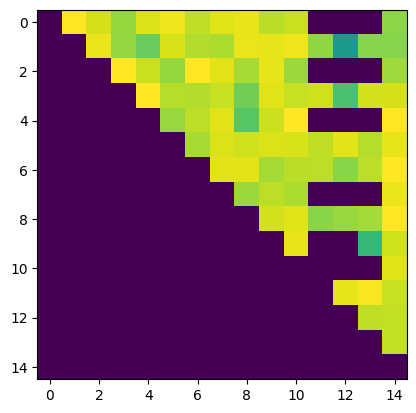

In [46]:
plt.imshow(ratios.T)

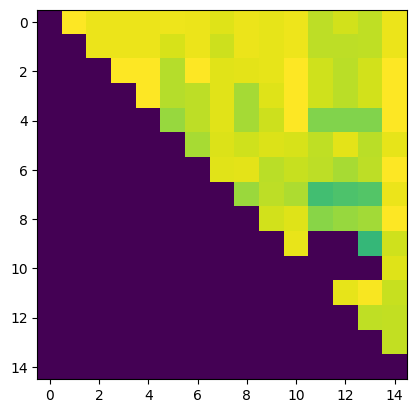

In [47]:
plt.imshow(scores)

In [61]:
import networkx as nx

def minimal_spanning_tree(adj_matrix):
    # Create a graph from the adjacency matrix
    G = nx.Graph()
    num_nodes = len(adj_matrix)
    
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if adj_matrix[i][j] != 0:
                G.add_edge(i, j, weight=adj_matrix[i][j])
    
    mst = nx.minimum_spanning_tree(G)
    
    # Convert EdgeDataView to a list of edges
    mst_edges = list(mst.edges(data=True))
    
    return mst_edges


def create_symmetric_matrix(top_matrix):
    n = len(top_matrix)
    sym_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            sym_matrix[i][j] = top_matrix[i][j]
    sym_matrix += sym_matrix.T
    return sym_matrix


adjacency = create_symmetric_matrix(ratios.T)

In [64]:
scores = -np.log(adjacency)
tree = minimal_spanning_tree(scores)
nodes = [(x[0], x[1]) for x in tree]
print(nodes)


[(0, 5), (0, 8), (2, 1), (3, 9), (4, 7), (5, 14), (5, 12), (6, 8), (7, 14), (8, 1), (9, 10), (10, 1), (11, 13), (11, 12)]


/tmp/ipykernel_34426/276787354.py:1: RuntimeWarning: divide by zero encountered in log
  scores = -np.log(adjacency)


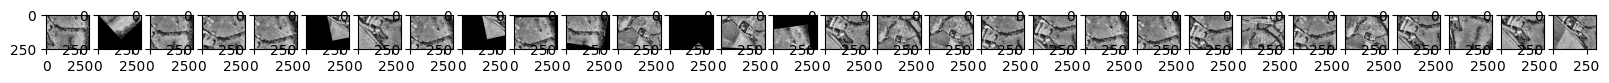

In [66]:
# align all the images to 0 based on nodes
aligned_images = [images[0]]
for i in range(1,len(images)):
    H = np.eye(3)
    for node in nodes:
        if node[1] == i:
            H = np.dot(H, match_sift_features(features[node[0]], features[node[1]])[0])
    aligned_images.append(cv2.warpPerspective(images[i],H,(images[0].shape[1],images[0].shape[0])))

# plot the aligned images
fig, ax = plt.subplots(1,len(aligned_images),figsize=(20,20))
for i in range(len(aligned_images)):
    ax[i].imshow(aligned_images[i],cmap='gray')
                          

In [ ]:
def maximize_score_with_spanning_tree(adj_matrix, start, end):
    num_nodes = len(adj_matrix)
    
    # Initialize scores and spanning tree
    scores = np.zeros(num_nodes)
    spanning_tree = [[] for _ in range(num_nodes)]
    scores[start] = 1
    
    # Dynamic programming to compute maximum score and spanning tree
    for _ in range(num_nodes - 1):
        for i in range(num_nodes):
            for j in range(num_nodes):
                if adj_matrix[i][j] != 0:
                    new_score = scores[i] * adj_matrix[i][j]
                    if new_score > scores[j]:
                        scores[j] = new_score
                        spanning_tree[j] = spanning_tree[i] + [(i, j)]
    
    # Reconstruct the optimal spanning tree
    optimal_spanning_tree = spanning_tree[end]
    
    return scores[end], optimal_spanning_tree

In [69]:
N

15

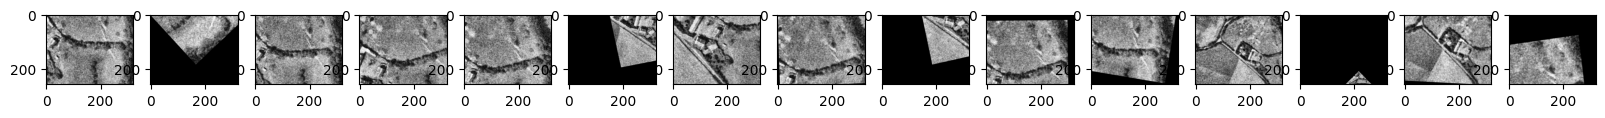

In [71]:
def maximize_score_with_spanning_tree(adj_matrix, start, end):
    num_nodes = len(adj_matrix)
    
    # Initialize scores and spanning tree
    scores = np.zeros(num_nodes)
    spanning_tree = [[] for _ in range(num_nodes)]
    scores[start] = 1
    
    # Dynamic programming to compute maximum score and spanning tree
    for _ in range(num_nodes - 1):
        for i in range(num_nodes):
            for j in range(num_nodes):
                if adj_matrix[i][j] != 0:
                    new_score = scores[i] * adj_matrix[i][j]
                    if new_score > scores[j]:
                        scores[j] = new_score
                        spanning_tree[j] = spanning_tree[i] + [(i, j)]
    
    # Reconstruct the optimal spanning tree
    optimal_spanning_tree = spanning_tree[end]
    
    return scores[end], optimal_spanning_tree

for num_image in range(N):
    adj_matrix = ratios.T
    start = 0
    end = num_image
    max_score, optimal_spanning_tree = maximize_score_with_spanning_tree(adj_matrix, start, end)
    
    # warp the image
    H = np.eye(3)
    for node in optimal_spanning_tree:
        H = np.dot(H, match_sift_features(features[node[0]], features[node[1]])[0])
    H = np.linalg.inv(H) 
    aligned_images.append(cv2.warpPerspective(images[num_image],H,(images[0].shape[1],images[0].shape[0])))

# plot the aligned images
fig, ax = plt.subplots(1,N,figsize=(20,20))
for i in range(N):
    ax[i].imshow(aligned_images[i],cmap='gray')
